## 库

In [1]:
from urllib.request import quote, urlopen
import base64
import re
from time import sleep

In [2]:
from selenium.webdriver.common.keys import Keys

In [4]:
from driverOps import getDriver, newLabel, switchLabel, waitTillOpen, closeAllOther

In [5]:
from PIL import Image
import io
from vVariableInspector import _getshapeof

## 爬取信息

### 打开浏览器

In [76]:
driver = getDriver(0)

### 函数

#### 显示b64图片

In [16]:
def b64pic2img (pic):
    return Image.open(io.BytesIO(base64.b64decode(pic)))

#### 采集学者信息

In [72]:
driver.find_elements?

In [73]:
class AminerScholarExtracter:
    __version__ = 20210125
    def __init__ (this, dv):
        this.__dv = dv
        this.__wait = 10
        this.__waitUnit = 2
    def __getTextByXpath (this, path, dv=None):
        if dv is None: dv = this.__dv
        rst = dv.find_elements_by_xpath(path)
        if not rst: return None
        return rst[0].text
    def __getAttributeByXpath (this, path, attribute, dv=None):
        if dv is None: dv = this.__dv
        rst = dv.find_elements_by_xpath(path)
        if not rst: return None
        return rst[0].get_attribute(attribute)
    def __getTextById (this, tid):
        rst = this.__dv.find_elements_by_id(tid)
        if not rst: return None
        return rst[0].text
    def __getTextsByXpath (this, path):
        rst = this.__dv.find_elements_by_xpath(path)
        return [x.text for x in rst]
    def __clickIfNotActive (this, element, secWait, pathWait):
        dv = this.__dv
#         dv.execute_script('arguments[0].scrollIntoView();', element)
        if 'active' not in element.get_attribute('class'): 
#             element.click()
            dv.execute_script('arguments[0].click();', element)
#             sleep(secWait)
            waitTillOpen(dv, secWait, value=pathWait)
    def __stdId (this, aid):
        '''
        去除id开头的'pid_'
        '''
        return aid[4:] if aid.startswith('pid_') else aid
    
    def getId (this):
        return this.__stdId(this.__dv.current_url.split('/')[-1])
    def getPortrait (this):
        path =  '//*[contains(@class, "profile")]' \
                        '//*[contains(@class, "avatar")]' \
                        '//img[contains(@class, "avatar")]'
        portraits = this.__getAttributeByXpath(path, 'src')
        if portraits is None: return None
        return base64.b64encode(urlopen(portraits).read())
    def getNameOld (this):
        #pathPinyin = '//h1[contains(@class,name)]/span/span[@class="sub"]'
        path = '//h1[contains(@class,"name")]/span'
        
        names = this.__dv.find_elements_by_xpath(path)
        if not names: return (None, None)
        rst = re.findall(r'([^()（）]+)[(（]?([^()（）]*)[)）]?', names[0].text)[0]
        return (rst[0], rst[1] if rst[1] else None)
    
    def getName (this):
        idName = 'scholar_name_LymphV'
        idPinyin = 'scholar_pinyin_LymphV'
        
        ###直接运行js会出现circular reference错误
        if this.__getTextById(idName) is None:
            driver.execute_script(f'''
                script= document.createElement('script');
                script.text = '\
                    sname = document.createElement("p");\
                    sname.setAttribute("id", "{idName}");\
                    sname.textContent = document.querySelector("h1[class*=name] span").childNodes[0].textContent;\
                    document.getElementsByTagName("body")[0].appendChild(sname);\
                    pyname = document.createElement("p");\
                    pyname.setAttribute("id", "{idPinyin}");\
                    pyname.textContent = document.querySelector("h1[class*=name] span span.sub").childNodes[1].textContent;\
                    document.getElementsByTagName("body")[0].appendChild(pyname);'
                document.getElementsByTagName('body')[0].appendChild(script);
            ''')
        return (this.__getTextById(idName), this.__getTextById(idPinyin))
        
    def getTitle (this):
        path = '//*[contains(@class,"briefcase")]/../span'
        return this.__getTextByXpath(path)
    def getDepartment (this):
        path = '//*[contains(@class,"institution")]/../span'
        return this.__getTextByXpath(path)
    def getPhone (this):
        path = '//*[contains(@class,"phone")]/../span'
        return this.__getTextByXpath(path)
    def getEmail (this):
        path = '//*[contains(@class,"envelope")]/../span'
        return this.__getTextByXpath(path)
    def getWebPages (this):
        path = '//*[contains(@class,"globe")]/../a'
        return this.__getTextsByXpath(path)
    def getFax (this):
        path = '//*[contains(@class,"fax")]/../span'
        return this.__getTextByXpath(path)
    def getAddress (this):
        path = '//*[contains(@class,"map-marker")]/../span'
        return this.__getTextByXpath(path)
    def getAwards (this):
        path = '//*[contains(@class,"awards_title")]/..//img/..'
        return this.__getTextsByXpath(path)
    def getTalentPools (this):
        path = '//*[contains(@class,"eb_title")]/../span'
        return this.__getTextsByXpath(path)
    
    
    def getExperience (this):
        pathBasic = '//*[contains(@class,"ant-tabs-nav-list")]/*[1]'
        path = '//*[contains(@class,"active")]//*[@class="aff_inst"]/div'
        basic = this.__dv.find_elements_by_xpath(pathBasic)
        if not basic: return None
        basic = basic[0]
        this.__clickIfNotActive(basic, this.__wait, path)
        return this.__getTextByXpath(path)
    def getEducation (this):
        pathBasic = '//*[contains(@class,"ant-tabs-nav-list")]/*[1]'
        path = '//*[contains(@class,"active")]//*[contains(@class,"education")]'
        basic = this.__dv.find_elements_by_xpath(pathBasic)
        if not basic: return None
        basic = basic[0]
        this.__clickIfNotActive(basic, this.__wait, path)
        return this.__getTextByXpath(path)
    def getBrief (this):
        pathBasic = '//*[contains(@class,"ant-tabs-nav-list")]/*[1]'
        path = '//*[contains(@class,"active")]//*[contains(@class,"bio")]'
        basic = this.__dv.find_elements_by_xpath(pathBasic)
        if not basic: return None
        basic = basic[0]
        this.__clickIfNotActive(basic, this.__wait, path)
        return this.__getTextByXpath(path)
    
    def getPapers (this):
        pathAchievements  = '//*[contains(@class,"ant-tabs-nav-list")]/*[2]'
        pathRefSort = '//*[contains(@class,"pubs_sort_line")]/div/*[2]'
        
        pathPaper = '//*[contains(@class,"pubs_sort_line")]/div'\
                    '/*[2 and contains(@class,"active")]/../../../../..'\
                    '//*[@class="content"]'
        pathId = '..'
        pathTitle = './/*[contains(@class,"title")]/span'
        pathAuthor = './/*[contains(@class,"authors")]'
        pathVenue = './/*[contains(@class,"venue-line")]'
        pathCited = './/*[@class="cited"]/strong'
        pathLoading = '//*[contains(@class,"sk_chase")]'
        
        achievements = this.__dv.find_elements_by_xpath(pathAchievements)
        if not achievements: return []
        achievements = achievements[0]
        if 'disabled' in achievements.get_attribute('class'):
            return []
        this.__clickIfNotActive(achievements, this.__wait, pathRefSort)
        refSort = this.__dv.find_elements_by_xpath(pathRefSort)
        if not refSort: return []
        refSort = refSort[0]
        this.__clickIfNotActive(refSort, this.__wait, pathPaper)
        for i in range(20):
            if not this.__dv.find_elements_by_xpath(pathLoading):
                break
            sleep(0.25)
        if this.__dv.find_elements_by_xpath(pathLoading): return []
        
        papers = this.__dv.find_elements_by_xpath(pathPaper)
        return [{
            "id" : this.__stdId(this.__getAttributeByXpath(pathId, 'id', p)),
            "title" : this.__getTextByXpath(pathTitle, p),
            "author" : this.__getTextByXpath(pathAuthor, p),
            "venue" : this.__getTextByXpath(pathVenue, p),
            "cited" : this.__getTextByXpath(pathCited, p)
        } for p in papers]
        

### 抽取

#### 抽id和名字

In [291]:
AminerScholarExtracter(driver).getId(), \
AminerScholarExtracter(driver).getName(), \
AminerScholarExtracter(driver).getNameOld()

('5486da4adabfae9b4013409a', ('程学旗', 'Xueqi Cheng'), ('程学旗', 'Xueqi Cheng'))

#### 抽头像

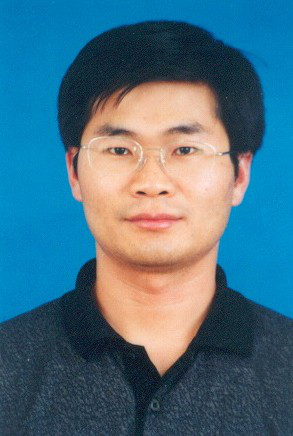

In [54]:
b64pic2img(AminerScholarExtracter(driver).getPortrait())

#### 抽职称、机构、邮箱

In [222]:
AminerScholarExtracter(driver).getTitle(), \
AminerScholarExtracter(driver).getDepartment(),\
AminerScholarExtracter(driver).getEmail(),

('教授', '中国科学院计算技术研究所', 'cxq@ict.ac.cn')

#### 抽电话、传真、住址

In [265]:
AminerScholarExtracter(driver).getPhone(), \
AminerScholarExtracter(driver).getFax(),\
AminerScholarExtracter(driver).getAddress(),

(None, None, None)

#### 抽网址

In [262]:
AminerScholarExtracter(driver).getWebPages()

['http://www.bigdatalab.ac.cn/~cxq/',
 'https://scholar.google.com/citations?hl=en&user=hY8aLqAAAAAJ&view_op=list_works&sortby=pubdate',
 'http://people.ucas.ac.cn/~cxq',
 'https://dblp.uni-trier.de/pers/c/Cheng:Xueqi.html']

#### 抽奖项

In [267]:
AminerScholarExtracter(driver).getAwards()

['2018 AMiner Top 10 AI-10 Most Influential Scholar Award in Data Mining',
 '2016 AMiner Top 10 Most Influential Scholar Award in Data Mining',
 '2016 AMiner Most Influential Scholar Award in Computer Network']

#### 抽人才库

In [269]:
AminerScholarExtracter(driver).getTalentPools()

['AI 2000 人工智能最具影响力学者排行', 'KDD非华人库[2020]', 'ACM Fellow[2010]']

#### 抽工作经历

In [257]:
print(AminerScholarExtracter(driver).getExperience())

2017-01~现在, 中国科学院计算技术研究所, 副所长
2017-01~现在, 中国科学院计算技术研究所, 大数据分析技术国家工程实验室副主任
2004-03~现在, 中科院计算所, 研究员，中科院网络数据科学与技术重点实验室主任，副总工程师
2000-03~2004-02,中科院计算所, 副研究员，软件研究室主任
1996-04~2000-02,国家智能计算机研究开发中心, 工程师


#### 抽教育背景

In [259]:
print(AminerScholarExtracter(driver).getEducation())

2000-09-2006-06 中科院计算所，计算机系统结构专业，工学博士学位
1993-09-1996-04 东北大学计算机系，计算机科学与理论专业，工学硕士学位
1989-09-1993-07 东北大学计算机系，计算机应用专业，工学学士学位


#### 抽个人简介

In [260]:
print(AminerScholarExtracter(driver).getBrief())

Research Areas
Network Science and Social Computing
Web Search and Mining
Internet Information Security
Distributed System and Mass Simulation Platform

Teaching Experiences
Social Informational Network Analysis
Statistical Machine Learning: Theories, Algorithms and Tools
Computing Models and Algorithmic Theories of Informational Network
The Elements of Statistical Machine Learning


#### 抽文献

In [369]:
AminerScholarExtracter(driver).getPapers()

[{'id': 'pid_53e9bd98b7602d9704a4068c',
  'title': 'A biterm topic model for short texts',
  'author': 'Xiaohui Yan,\nJiafeng Guo,\nYanyan Lan,\nXueqi Cheng',
  'venue': 'WWW, pp.1445-1456, (2013)'},
 {'id': 'pid_573696396e3b12023e545921',
  'title': 'Significance and Challenges of Big Data Research',
  'author': 'Xiaolong Jin,\nBenjamin W. Wah,\nXueqi Cheng,\nYuanzhuo Wang',
  'venue': 'Big Data Research, no. 2 (2015): 59-64'},
 {'id': 'pid_53e9afdbb7602d9703a3191d',
  'title': 'Named entity recognition in query',
  'author': 'Jiafeng Guo,\nGu Xu,\nXueqi Cheng,\nHang Li',
  'venue': 'SIGIR, pp.267-274, (2009)'},
 {'id': 'pid_53e9a89bb7602d97031e8a47',
  'title': 'Detect overlapping and hierarchical community structure in networks',
  'author': 'Huawei Shen,\nXueqi Cheng,\nKai Cai,\nMao-Bin Hu',
  'venue': 'Physica A-statistical Mechanics and Its Applications, no. 8 (2009): 1706-1712'},
 {'id': 'pid_5b076eb4da5629516ce735fa',
  'title': 'Survey on big data system and analytic technolog

## 打开每个学者的页面

### 函数

#### 学者名字跳转

In [27]:
def searchName (dv, name):
    pathLoading = '//span[contains(@class,"ant-spin")]'
    dv.get(f'https://gct.aminer.cn/eb/search?key={quote(name)}')
    sleep(2)
    ###等待排序完成
    for i in range(20):
        if not dv.find_elements_by_xpath(pathLoading):
            break
        sleep(0.25)
    if dv.find_elements_by_xpath(pathLoading): return False
    return True

#### 打开学者页

In [9]:
def getScholarPage (dv, sid):
    dv.get(f'https://top3-talent.com/market/eb/profile/{sid}')#### 学者名字跳转

#### id标准化

In [12]:
def stdId (id):
        '''
        去除id开头的'pid_'
        '''
        return id[4:] if id.startswith('pid_') else id

#### 抽取学者id列表

In [37]:
def getScholarIds (dv, name):
    path = '//*[contains(@id,"pid_")]'
    pathName = './/strong//span[1]'
    pathNextPage = '//li[contains(@class,"next")]'
    pathLoading = '//span[contains(@class,"ant-spin")]'
    
    rst = []
    
    while 1:
        print (".")
        rst += [
            stdId(x.get_attribute('id')) 
            for x in dv.find_elements_by_xpath(path) 
            if x.find_elements_by_xpath(pathName) 
            and x.find_elements_by_xpath(pathName)[0].text == name
        ]
        
        nextPage = dv.find_elements_by_xpath(pathNextPage)
        if not nextPage or nextPage[0].get_attribute('aria-disabled') != 'false':
            break
        dv.execute_script('arguments[0].click();', nextPage[0])
        
        sleep(2)
        ###等待排序完成
        for i in range(20):
            if not dv.find_elements_by_xpath(pathLoading):
                break
            sleep(0.25)
        if dv.find_elements_by_xpath(pathLoading): return None
    
    return rst

### 抽取

#### 打开学者列表

In [30]:
name = '张伟'

In [28]:
searchName(driver, name)

True

#### 获取id列表

In [38]:
ids = getScholarIds(driver, name)
ids

.
.
.
.
.
.


['53f4b8f6dabfaed83b77b41e',
 '53f4b8f6dabfaed83b77b415',
 '53f4b8f7dabfaed83b77b448',
 '5429da48dabfaec7081c076e',
 '562cc2a445ce1e59676a45ec',
 '53f31a62dabfae9a84431200',
 '5433932bdabfaebba581977b',
 '5429d8cddabfaec7081c0238',
 '56166f5c45ce1e59639b63f2',
 '542a1f04dabfae81b7d54091',
 '5429d9e8dabfaec7081c061a',
 '542de62bdabfae11fc4af071',
 '542e1d09dabfae11fc4c5e93',
 '5429d8f7dabfaec7081c02cd',
 '542d0a62dabfae498ae16b1c',
 '561b11b345ce11c523c9331a',
 '53f4b8f8dabfaed83b77b51e',
 '5429d8eadabfaec7081c029d',
 '560f67f345cedb339772e791',
 '56cb18a6c35f4f3c656591eb',
 '561de23145ce11c523cb1498',
 '5613f15545cedb3397a0e140',
 '561f582445ceff436be1c524']

In [39]:
ix =['561f582445ceff436be1c524']

In [47]:
ix = [ '5613f15545cedb3397a0e140']

In [54]:
ix = ['5429da48dabfaec7081c076e']

In [65]:
ix = ['5486da4adabfae9b4013409a']

In [79]:
ix = ['561f58bc45cedb33981bc85e']

#### 抽取

In [80]:
for id in ix:
    getScholarPage(driver, id)
    print (AminerScholarExtracter(driver).getName())
    print (AminerScholarExtracter(driver).getTitle())
    print (AminerScholarExtracter(driver).getDepartment())
    print(AminerScholarExtracter(driver).getPapers())
    closeAllOther(driver)

('李伟', 'Wei Li')
副教授
School of Materials Science and Engineering, Shanghai Jiaotong University
[{'id': '56d91ff1dabfae2eee978f86', 'title': 'Hydrogen trapping sites and hydrogen-induced cracking in high strength quenching & partitioning (Q&P) treated steel', 'author': 'xu zhu,\nwei li,\nhongshan zhao,\nli wang\n,\nxuejun jin', 'venue': 'International Journal of Hydrogen Energy, no. 24 (2014): 13031-13040', 'cited': '46'}, {'id': '56d90ef1dabfae2eee2efa31', 'title': 'Effect of Retained Austenite on the Fracture Toughness of Quenching and Partitioning (Q&P)-Treated Sheet Steels', 'author': 'riming wu\n,\nwei li,\nshu zhou\n,\nyong zhong\n,\nli wang\n,\nxuejun jin', 'venue': 'Metallurgical and Materials Transactions A-physical Metallurgy and Materials Science, no. 4 (2013): 1892-1902', 'cited': '28'}, {'id': '53e9a408b7602d9702d20055', 'title': 'Effect of tensile stress on the formation of S-phase during low-temperature plasma carburizing of 316L foil', 'author': 'Wei Li,\nXiaoying Li,\nH

In [379]:
switchLabel(driver, -1)

In [377]:
driver.close()

### 关闭浏览器

In [81]:
driver.quit()